In [100]:
import numpy as np
import scipy as sci
from trackhhl.toy import simple_generator as toy
from trackhhl.hamiltonians import simple_hamiltonian as hamiltonian
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [101]:
def cartesian_to_spherical_vectorized(cartesian_coords, translation=(0, 0, 0)):
    x, y, z = cartesian_coords[:, 0] - translation[0], cartesian_coords[:, 1] - translation[1], cartesian_coords[:, 2] - translation[2]
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z / r)
    return r, theta, phi

def calc_phi(cartesian_coords):
    x, y, _ = cartesian_coords[:, 0], cartesian_coords[:, 1], cartesian_coords[:, 2]
    phi = np.arctan2(y, x)
    return phi

def split_by_phi(data, phi_range):
    sorted_data = data[data[:, 3].argsort()]
    split_indices = np.where(np.diff(sorted_data[:, 3]) > phi_range)[0] + 1
    subarrays = np.split(sorted_data, split_indices)
    return subarrays

In [125]:
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)

N_PARTICLES = 100
N_EVENTS = 1
SIGMA = (0,0,0.5)
events = generator.generate_event(N_PARTICLES, N_EVENTS, SIGMA)
test_type = []

if type(events) != type(test_type):
    events = [events]
#event = events[0]


In [126]:
hits_by_event_track = defaultdict(list)

for event_id, event in enumerate(events):
    for hit in event.hits:
        key = (event_id, hit.track_id)
        hits_by_event_track[key].append(hit)

hits_by_event_track = dict(hits_by_event_track)

#for (event_id, track_id), track_hits in hits_by_event_track.items():
#    print(f"Event ID: {event_id}, Track ID: {track_id}")
#    print(np.array(track_hits))
#   print()


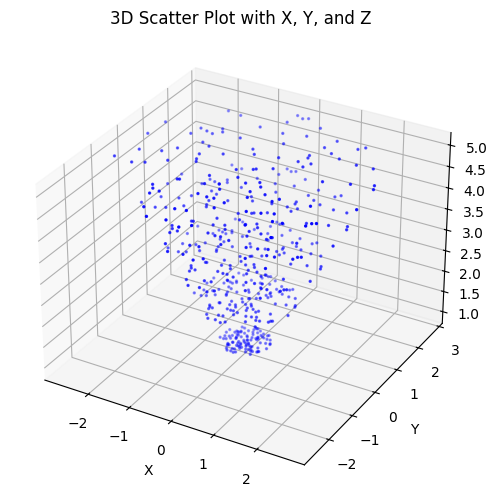

In [127]:
event_hits = []
events_store = []
for event_ in events:
    for hit in event_.hits:
        event_hits.append([hit.x,hit.y,hit.z,hit.track_id])
    events_store.append(event_hits)
structured_array = np.array(events_store)
cartesian_coords = structured_array[:, :, :3]  
fig = plt.figure(figsize=(12, 6)) # , dpi=450)
ax = fig.add_subplot(111, projection='3d')
for structured_array_ in structured_array:
    ax.scatter(structured_array_[:,0], structured_array_[:,1], structured_array_[:,2], c='b', marker='o', s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Scatter Plot with X, Y, and Z')
plt.show()

In [128]:

cartesian_list = cartesian_coords[0].tolist()

phi = calc_phi(cartesian_coords[0])
for i in range(len(cartesian_coords[0,:])):
    cartesian_list[i].append(phi[i])
cartesian_list = np.array(cartesian_list)
transformed_list = []
placeholder_list = []
collection = []
while len(transformed_list) < len(generator.primary_vertices):
    phi_value = np.random.uniform(0, 2*np.pi)
    phi_range_mask = np.logical_and(phi >= phi_value - 2, phi <= phi_value + 2)
    selected_points = cartesian_list[phi_range_mask]

    result = split_by_phi(selected_points, 0.000001)
    #print(result)
    z_0 = []
    for res in result:
        if res.size == 0: continue
        m, c = np.polyfit(res[:, 0], res[:, 2], 1)
        z_0.append(c)
    for coll in z_0:
        collection.append(np.round(coll,6))
        
    uniqe_z0 = np.unique(np.round(z_0,6))

    #print(uniqe_z0)
    for element in uniqe_z0:
        if element not in placeholder_list: 
            sublist = [0, 0, element]
            placeholder_list.append(element)
            transformed_list.append(sublist)
print(generator.primary_vertices)
print(transformed_list)
print('Original vertrex number', len(generator.primary_vertices), '  Found vertices', len(transformed_list))
print(len(collection))

[(0, 0, 0)]
[[0, 0, -0.0]]
Original vertrex number 1   Found vertices 1
43


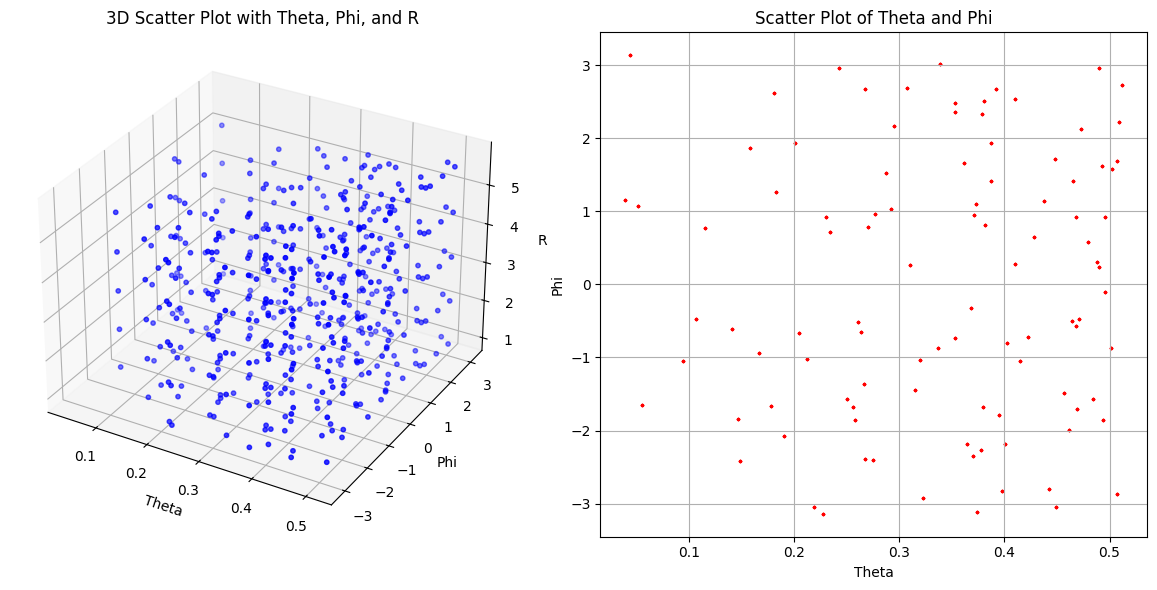

In [129]:

for vert in transformed_list:#generator.primary_vertices:
    r = []
    theta = []
    phi = []
    for coord in cartesian_coords:
        r_, thetas_, phi_ = cartesian_to_spherical_vectorized(coord, vert)
        r.append(r_)
        theta.append(thetas_)
        phi.append(phi_)

    fig = plt.figure(figsize=(18, 6))#, dpi=450)

    # Plot the 3D scatter plot with Theta, Phi, and R
    ax1 = fig.add_subplot(131, projection='3d')
    for i in range(len(r)):
        ax1.scatter(theta[i], phi[i], r[i], c='b', marker='o', s=10)  
    ax1.set_xlabel('Theta')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('R')
    ax1.set_title('3D Scatter Plot with Theta, Phi, and R')

    # Create a scatter plot with just Theta and Phi
    ax2 = fig.add_subplot(132)
    for i in range(len(theta)):
        ax2.scatter(theta[i], phi[i], c='r', marker='o', s=2)  
    ax2.set_xlabel('Theta')
    ax2.set_ylabel('Phi')
    ax2.set_title('Scatter Plot of Theta and Phi')

    plt.grid()
    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()


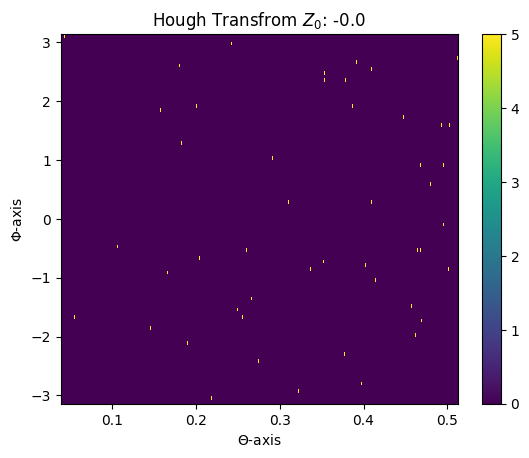

In [130]:
hist = []
hist1 = []
theta_axis = []
phi_axis = []
bins = (1000, 100)
for i, vert in enumerate(transformed_list):#generator.primary_vertices):
   
    r, theta, phi = cartesian_to_spherical_vectorized(cartesian_coords[i], vert)

    hist.append(sci.sparse.csr_matrix(np.histogram2d(theta, phi, bins=bins)[0]))
    hist1.append(np.histogram2d(theta, phi, bins=bins)[0])
    theta_axis.append(np.histogram2d(theta, phi, bins=bins)[1])
    phi_axis.append(np.histogram2d(theta, phi, bins=bins)[2])


    plt.hist2d(theta, phi, bins=bins, cmap='viridis')
    plt.colorbar()
    plt.xlabel('$\Theta$-axis')
    plt.ylabel('$\Phi$-axis')
    plt.title(f'Hough Transfrom $Z_0$: {np.round(vert[2],2)}')
    plt.show()


In [124]:
tracks = []
nonzero_tracks = 0
for num, h in enumerate(hist):
    sparse = h
    sparse.data[sparse.data <=4]= 0
    sparse.eliminate_zeros()
    row_indices, col_indices = sparse.nonzero()
    for i,j in zip(row_indices, col_indices):
        tracks.append((theta_axis[num][i],phi_axis[num][j], transformed_list[num][2]))
print(len(tracks))
print(np.array(tracks))


10
[[ 0.17516901 -2.70207416  0.        ]
 [ 0.19393588 -1.3642899   0.        ]
 [ 0.30917106 -0.08224664  0.        ]
 [ 0.32003609 -1.30854889  0.        ]
 [ 0.33024264  2.48183986  0.        ]
 [ 0.33057188 -0.8626208   0.        ]
 [ 0.41617516 -2.25614607  0.        ]
 [ 0.44053917 -0.41669271  0.        ]
 [ 0.46786637  2.81628593  0.        ]
 [ 0.50408314 -1.58725394  0.        ]]


In [109]:
def check_point_on_line(x, y, z, theta, phi, z_0, tolerance=1e-6):
    # Calculate r, theta', and phi'
    r = np.sqrt(x**2 + y**2 + (z - z_0)**2)
    theta_prime = np.arccos((z - z_0) / r)
    phi_prime = np.arctan2(y, x)

    # Check if theta' and phi' are close to the given theta and phi
    theta_check = np.isclose(theta_prime, theta, atol=tolerance)
    phi_check = np.isclose(phi_prime, phi, atol=tolerance)

    return theta_check, phi_check

for hit in hits_by_event_track[(0,0)]:
    print(check_point_on_line(hit.x, hit.y, hit.z, tracks[0][0], tracks[0][1], tracks[0][2], tolerance=1e-2))



(False, False)
(False, False)
(False, False)
(False, False)
(False, False)


In [110]:
histograms = hist1

theta_axis
phi_axis

data_with_histogram_info = []
for i, histogram in enumerate(histograms):
    x_indices, y_indices = np.where(histogram >= 4)
    histogram_indices = np.full((len(x_indices),3), generator.primary_vertices[i])
    data_points = np.column_stack((theta_axis[i][x_indices], phi_axis[i][y_indices], histogram_indices))
    data_with_histogram_info.append(data_points)
final_data = np.vstack(data_with_histogram_info)
print(len(final_data))

101


In [111]:
for (event_id, track_id), track_hits in hits_by_event_track.items():
    print(f"Event ID: {event_id}, Track ID: {track_id}")
    print(np.array(track_hits))
    print()

Event ID: 0, Track ID: 0
[Hit(hit_id=0, x=-0.14323991770702418, y=-0.31303957498298274, z=1.0, module_id=0, track_id=0)
 Hit(hit_id=1, x=-0.2691268381941152, y=-0.5881555392758263, z=2.0, module_id=1, track_id=0)
 Hit(hit_id=2, x=-0.39501375868120625, y=-0.8632715035686699, z=3.0, module_id=2, track_id=0)
 Hit(hit_id=3, x=-0.5209006791682972, y=-1.1383874678615133, z=4.0, module_id=3, track_id=0)
 Hit(hit_id=4, x=-0.6467875996553881, y=-1.413503432154357, z=5.0, module_id=4, track_id=0)]

Event ID: 0, Track ID: 1
[Hit(hit_id=5, x=0.3240254420223638, y=0.09043247324440445, z=1.0, module_id=0, track_id=1)
 Hit(hit_id=6, x=0.6087963753532167, y=0.1699093798986944, z=2.0, module_id=1, track_id=1)
 Hit(hit_id=7, x=0.8935673086840694, y=0.24938628655298428, z=3.0, module_id=2, track_id=1)
 Hit(hit_id=8, x=1.1783382420149222, y=0.32886319320727414, z=4.0, module_id=3, track_id=1)
 Hit(hit_id=9, x=1.463109175345775, y=0.40834009986156405, z=5.0, module_id=4, track_id=1)]

Event ID: 0, Track ID

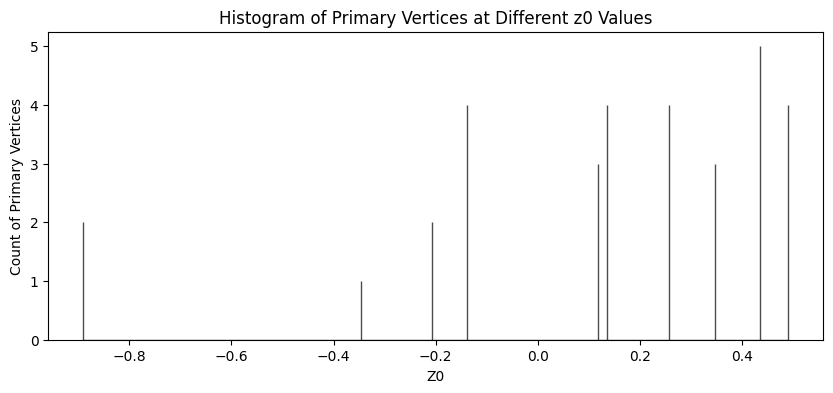

In [112]:
fig, ax = plt.subplots(figsize=(10, 4)) #, dpi=450)
# Create a histogram
plt.hist(collection, bins=np.arange(min(collection), max(collection) + 0.0002, 0.0002), edgecolor='black', alpha=0.7)

# Set labels and title
plt.xlabel('Z0')
plt.ylabel('Count of Primary Vertices')
plt.title('Histogram of Primary Vertices at Different z0 Values')

# Show the plot
plt.show()